In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/My Drive/uni_assignments/COS30082/face_recognition_dataset/11-785-fall-20-homework-2-part-2.zip" -d "/content/data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/verification_data/00064099.jpg  
  inflating: /content/data/verification_data/00064100.jpg  
  inflating: /content/data/verification_data/00064101.jpg  
  inflating: /content/data/verification_data/00064102.jpg  
  inflating: /content/data/verification_data/00064103.jpg  
  inflating: /content/data/verification_data/00064104.jpg  
  inflating: /content/data/verification_data/00064105.jpg  
  inflating: /content/data/verification_data/00064106.jpg  
  inflating: /content/data/verification_data/00064107.jpg  
  inflating: /content/data/verification_data/00064108.jpg  
  inflating: /content/data/verification_data/00064109.jpg  
  inflating: /content/data/verification_data/00064110.jpg  
  inflating: /content/data/verification_data/00064111.jpg  
  inflating: /content/data/verification_data/00064112.jpg  
  inflating: /content/data/verification_data/00064113.jpg  
  inflating: /content/data/verification_data/0006

In [4]:
!ls "/content/data/classification_data/train_data/n003212"

0013_01.jpg  0083_03.jpg  0151_01.jpg  0226_01.jpg  0285_01.jpg  0333_01.jpg
0014_01.jpg  0086_01.jpg  0151_02.jpg  0231_01.jpg  0287_01.jpg  0337_01.jpg
0024_01.jpg  0087_01.jpg  0159_04.jpg  0232_01.jpg  0290_02.jpg  0345_01.jpg
0029_02.jpg  0099_01.jpg  0160_01.jpg  0236_01.jpg  0294_01.jpg  0346_01.jpg
0033_01.jpg  0109_01.jpg  0163_01.jpg  0239_01.jpg  0296_02.jpg  0348_01.jpg
0034_01.jpg  0110_01.jpg  0164_01.jpg  0245_01.jpg  0304_01.jpg  0351_01.jpg
0042_01.jpg  0111_01.jpg  0172_01.jpg  0250_01.jpg  0305_01.jpg  0364_01.jpg
0050_01.jpg  0120_01.jpg  0187_01.jpg  0260_03.jpg  0311_01.jpg  0370_01.jpg
0053_02.jpg  0121_02.jpg  0191_02.jpg  0263_01.jpg  0314_01.jpg  0386_01.jpg
0061_01.jpg  0122_01.jpg  0193_02.jpg  0266_01.jpg  0315_01.jpg  0389_01.jpg
0062_02.jpg  0124_01.jpg  0202_01.jpg  0271_01.jpg  0317_01.jpg  0390_01.jpg
0070_01.jpg  0125_01.jpg  0207_02.jpg  0277_01.jpg  0322_01.jpg  0406_02.jpg
0075_01.jpg  0126_01.jpg  0208_02.jpg  0281_01.jpg  0324_03.jpg  0411_01.jpg

In [5]:
import os
TRAIN_DIR = "/content/data/classification_data/train_data/"
data_manifest = {}
for person_id in os.listdir(TRAIN_DIR):
    person_path = os.path.join(TRAIN_DIR, person_id)
    if os.path.isdir(person_path):
        images = [os.path.join(person_path, f) for f in os.listdir(person_path)]
        # You need at least 2 images to make an (Anchor, Positive) pair
        if len(images) > 1:
            data_manifest[person_id] = images

# This list will be used to pick random people
person_ids_list = list(data_manifest.keys())

In [6]:
# Display the first 5 entries of data_manifest to check its structure
from itertools import islice

def display_dict_head(dictionary, num_entries=5):
    print(dict(islice(dictionary.items(), num_entries)))

display_dict_head(data_manifest)

{'n002224': ['/content/data/classification_data/train_data/n002224/0062_01.jpg', '/content/data/classification_data/train_data/n002224/0092_01.jpg', '/content/data/classification_data/train_data/n002224/0463_01.jpg', '/content/data/classification_data/train_data/n002224/0031_01.jpg', '/content/data/classification_data/train_data/n002224/0082_01.jpg', '/content/data/classification_data/train_data/n002224/0035_01.jpg', '/content/data/classification_data/train_data/n002224/0021_01.jpg', '/content/data/classification_data/train_data/n002224/0060_01.jpg', '/content/data/classification_data/train_data/n002224/0041_06.jpg', '/content/data/classification_data/train_data/n002224/0054_01.jpg', '/content/data/classification_data/train_data/n002224/0039_04.jpg', '/content/data/classification_data/train_data/n002224/0117_01.jpg', '/content/data/classification_data/train_data/n002224/0007_03.jpg', '/content/data/classification_data/train_data/n002224/0004_01.jpg', '/content/data/classification_data/

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import random
import numpy as np
from glob import glob

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Lambda, BatchNormalization, Activation
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory

# --- Define project constants ---
IMAGE_SIZE = (224, 224) # Use 224x224 for ResNet50
BATCH_SIZE = 32
EMBEDDING_DIM = 128
MARGIN = 0.5
ROOT_DIR = "/content/data/" # Use a root variable

# Update paths to use the root dir
TRAIN_DIR = os.path.join(ROOT_DIR, "classification_data/train_data")
VAL_DIR = os.path.join(ROOT_DIR, "classification_data/val_data")
PAIRS_FILE = os.path.join(ROOT_DIR, "verification_pairs_val.txt")
PAIRS_BASE_DIR = ROOT_DIR # The pairs file paths are relative to this

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU is {'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE'}")

%matplotlib inline

TensorFlow version: 2.19.0
GPU is available


In [8]:
def load_and_prep(image_path):
    """Loads, augments, and preprocesses a single image file path."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # --- Data Augmentation ---
    # Resize to slightly larger, then random crop.
    # This simulates "different view points" by forcing the model
    # to find the face even if it's not centered.
    image = tf.image.resize(image, (256, 256))
    image = tf.image.random_crop(image, (IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)

    # --- Normalization (CRITICAL) ---
    image = resnet50_preprocess(image)
    return image

def triplet_generator():
    """A Python generator that yields file paths for (A, P, N) triplets."""
    while True:
        # 1. Pick Anchor and Positive
        anchor_id = random.choice(person_ids_list)
        anchor_path, positive_path = random.sample(data_manifest[anchor_id], 2)

        # 2. Pick Negative
        negative_id = random.choice(person_ids_list)
        while negative_id == anchor_id:
            negative_id = random.choice(person_ids_list)
        negative_path = random.choice(data_manifest[negative_id])

        yield (anchor_path, positive_path, negative_path)

# Define a separate generator for validation data
def val_triplet_generator():
    """A Python generator that yields file paths for (A, P, N) triplets for validation."""
    while True:
        # 1. Pick Anchor and Positive from validation data
        anchor_id = random.choice(val_person_ids_list)
        anchor_path, positive_path = random.sample(val_manifest[anchor_id], 2)

        # 2. Pick Negative from validation data
        negative_id = random.choice(val_person_ids_list)
        while negative_id == anchor_id:
            negative_id = random.choice(val_person_ids_list)
        negative_path = random.choice(val_manifest[negative_id])

        yield (anchor_path, positive_path, negative_path)


def load_triplet_images(anchor_path, positive_path, negative_path):
    """The main mapping function for tf.data"""
    return (
        load_and_prep(anchor_path),
        load_and_prep(positive_path),
        load_and_prep(negative_path)
    ), 0 # '0' is a dummy label, our loss function ignores it

# --- Create the final, optimized tf.data.Dataset ---
triplets_dataset = tf.data.Dataset.from_generator(
    triplet_generator,
    output_signature=(
        (tf.TensorSpec(shape=(), dtype=tf.string),
         tf.TensorSpec(shape=(), dtype=tf.string),
         tf.TensorSpec(shape=(), dtype=tf.string))
    )
)

# This is where the magic happens. We run everything in parallel.
triplets_dataset = triplets_dataset.map(
    load_triplet_images,
    num_parallel_calls=tf.data.AUTOTUNE
)
triplets_dataset = triplets_dataset.batch(BATCH_SIZE)
triplets_dataset = triplets_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# We do the same for a validation set
# (Assuming val_data has a similar structure)
# NOTE: You MUST create a separate validation manifest
print("Building validation manifest...")
val_manifest = {}
val_person_ids_list = []
for person_id in os.listdir(VAL_DIR):
    person_path = os.path.join(VAL_DIR, person_id)
    if os.path.isdir(person_path):
        images = glob(os.path.join(person_path, "*.jpg")) + \
                 glob(os.path.join(person_path, "*.png"))
        if len(images) > 1:
            val_manifest[person_id] = images
            val_person_ids_list.append(person_id)

# Use the separate generator for validation data
val_triplets_dataset = tf.data.Dataset.from_generator(
    val_triplet_generator,
    output_signature=(
        (tf.TensorSpec(shape=(), dtype=tf.string),
         tf.TensorSpec(shape=(), dtype=tf.string),
         tf.TensorSpec(shape=(), dtype=tf.string))
    )
).map(load_triplet_images, num_parallel_calls=tf.data.AUTOTUNE) \
 .batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Metric Learning Data Pipelines: READY")

Building validation manifest...
Metric Learning Data Pipelines: READY


In [9]:
# --- 1. Define the Embedding Engine (The "Engine" Upgrade) ---
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Lambda, BatchNormalization, Activation
from tensorflow.keras.applications import ResNet50

def l2_normalize_tf(v):
    return tf.math.l2_normalize(v, axis=1)

def create_embedding_engine(input_shape=(224, 224, 3), embedding_dim=128):
    """Loads ResNet50 and adds the embedding head."""
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the backbone for Stage 1 training
    base_model.trainable = False

    inputs = base_model.input
    x = base_model.output
    x = BatchNormalization()(x)
    x = Dense(embedding_dim, activation=None)(x)
    outputs = Lambda(l2_normalize_tf, output_shape=lambda s: s)(x)

    return Model(inputs, outputs, name="Embedding_Engine")

class SiameseModel(keras.Model):
    def __init__(self, embedding, loss="euclidean", margin=0.5):
        super().__init__()
        assert loss == "euclidean" or loss == "cosine", "loss must be either 'euclidean' or 'cosine'"
        self.embedding = embedding

        anchor_input = keras.Input(name="anchor", shape=self.embedding.input_shape[1:])
        positive_input = keras.Input(name="positive", shape=self.embedding.input_shape[1:])
        negative_input = keras.Input(name="negative", shape=self.embedding.input_shape[1:])

        anchor_embedding = self.embedding(anchor_input)
        positive_embedding = self.embedding(positive_input)
        negative_embedding = self.embedding(negative_input)

        self.siamese = keras.Model(
            inputs=[anchor_input, positive_input, negative_input],
            outputs=[anchor_embedding, positive_embedding, negative_embedding],
            name="Siamese_Trainer"
        )

        self.loss_type = loss
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.auc_metric = keras.metrics.AUC(name="auc")

    def __distance(self, anchor, other):
        if self.loss_type == "euclidean":
            return keras.ops.sum(keras.ops.square(anchor - other), axis=-1)

        # Cosine distance (1 - similarity)
        similarity = keras.ops.sum(anchor * other, axis=-1)
        return 1.0 - similarity

    def __triplet_loss(self, ap_distance, an_distance):
        return keras.ops.maximum(ap_distance - an_distance + self.margin, 0)

    def call(self, inputs):
        return self.siamese(inputs)

    def train_step(self, data):
        (anchors, positives, negatives), y = data
        with tf.GradientTape() as tape:
            anchor_emb, positive_emb, negative_emb = self([anchors, positives, negatives])
            ap_distance = self.__distance(anchor_emb, positive_emb)
            an_distance = self.__distance(anchor_emb, negative_emb)
            loss = self.__triplet_loss(ap_distance, an_distance)

        gradients = tape.gradient(loss, self.siamese.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.siamese.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.auc_metric.update_state(tf.ones_like(an_distance), an_distance)
        self.auc_metric.update_state(tf.zeros_like(ap_distance), ap_distance)
        return {"loss": self.loss_tracker.result(), "auc": self.auc_metric.result()}

    def test_step(self, data):
        (anchors, positives, negatives), y = data
        anchor_emb, positive_emb, negative_emb = self([anchors, positives, negatives])
        ap_distance = self.__distance(anchor_emb, positive_emb)
        an_distance = self.__distance(anchor_emb, negative_emb)
        loss = self.__triplet_loss(ap_distance, an_distance)
        self.loss_tracker.update_state(loss)
        self.auc_metric.update_state(tf.ones_like(an_distance), an_distance)
        self.auc_metric.update_state(tf.zeros_like(ap_distance), ap_distance)
        return {"loss": self.loss_tracker.result(), "auc": self.auc_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.auc_metric]

In [10]:
print("--- Training Metric Learning Model (Cosine) ---")

# 1. Create the engine (backbone is frozen by default)
embedding_cosine = create_embedding_engine(input_shape=(224, 224, 3), embedding_dim=EMBEDDING_DIM)
print(f"Engine created. Trainable vars (head): {len(embedding_cosine.trainable_variables)}")

# 2. Create the SiameseModel
siamese_cosine = SiameseModel(embedding_cosine, loss="cosine", margin=MARGIN)

# 3. Compile (Stage 1 - Training the head)
siamese_cosine.compile(optimizer=keras.optimizers.Adam(0.001))

print("Training head (backbone frozen)...")
history_cosine_head = siamese_cosine.fit(
    triplets_dataset,
    validation_data=val_triplets_dataset,
    epochs=10,
    steps_per_epoch=500, # Use 100 batches per epoch for a quick test
    validation_steps=50
)

# 4. Compile (Stage 2 - Fine-tuning the whole model)
print("\nUnfreezing backbone for fine-tuning...")
# --- THIS IS THE KEY OPTIMIZATION ---
# Set the *base_model* inside the engine to trainable
siamese_cosine.embedding.layers[1].trainable = True

# CRITICAL: Re-compile with a *very* low learning rate
siamese_cosine.compile(optimizer=keras.optimizers.Adam(1e-6))

print("Fine-tuning full model (backbone unfrozen)...")
history_cosine_full = siamese_cosine.fit(
    triplets_dataset,
    validation_data=val_triplets_dataset,
    epochs=20,
    steps_per_epoch=500,
    validation_steps=50,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            "model_siamese_cosine.weights.h5",
            save_best_only=True,
            save_weights_only=True,
            monitor="val_loss"
        )
    ]
)
print("--- Metric Learning (Cosine) Training Complete ---")

--- Training Metric Learning Model (Cosine) ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Engine created. Trainable vars (head): 4
Training head (backbone frozen)...
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 183s 305ms/step - auc: 0.7884 - loss: 0.2568 - val_auc: 0.8246 - val_loss: 0.2073
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 197s 394ms/step - auc: 0.8260 - loss: 0.2109 - val_auc: 0.8384 - val_loss: 0.2006
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 289ms/step - auc: 0.8395 - loss: 0.2004 - val_auc: 0.8490 - val_loss: 0.1938
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 202s 404ms/step - auc: 0.8380 - loss: 0.2006 - val_auc: 0.8547 - val_loss: 0.1771
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 289ms/step - auc: 0.8398 - loss: 0.1974 - val_auc: 0.8621 - val_loss: 0.1750
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 286ms/step - auc: 0.8457 - loss: 0.1911 - val_auc: 0.8397 - val_loss: 0.1986
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 285ms/step - auc: 0.8524 - loss: 0.1860 - val_au

In [11]:
print("hello")

hello


In [12]:
print("--- Preparing Classification Model ---")
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# --- 1. Create the data pipeline (FIX 2) ---
def preprocess_cls(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = resnet50_preprocess(image)
    return image, label

def augment_and_preprocess_cls(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = resnet50_preprocess(image)
    return image, label

cls_train_dataset_raw = image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    label_mode='int', # Use 'int'
    batch_size=BATCH_SIZE
)
# Get class names before mapping and prefetching
num_classes = len(cls_train_dataset_raw.class_names)

cls_train_dataset = cls_train_dataset_raw.map(augment_and_preprocess_cls, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

cls_val_dataset_raw = image_dataset_from_directory(
    VAL_DIR,
    image_size=IMAGE_SIZE,
    shuffle=False,
    label_mode='int', # Use 'int'
    batch_size=BATCH_SIZE
)
# Get class names before mapping and prefetching (though not strictly needed for validation here)
# num_classes_val = len(cls_val_dataset_raw.class_names) # Can add this if needed later


cls_val_dataset = cls_val_dataset_raw.map(preprocess_cls, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# --- 2. Build the Classification Model ---
# (This replaces your classification_head function)
def create_classification_model(backbone, num_classes):
    x = backbone.output
    # Removed the redundant GlobalAveragePooling2D layer
    # x = GlobalAveragePooling2D()(x) # Re-add pooling
    # This is the layer we will "steal" as the embedding
    x = Dense(1024, activation="relu", name="embedding_layer")(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    return Model(inputs=backbone.input, outputs=outputs)

# Create a *separate* backbone for the classifier
base_model_cls = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), pooling='avg')
base_model_cls.trainable = False # Make sure it's frozen

# Get the number of classes from the training dataset


classification_model = create_classification_model(base_model_cls, num_classes)

# --- 3. Train (Stage 1: Frozen) ---
classification_model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Training classification head (backbone frozen)...")
classification_model.fit(
    cls_train_dataset,
    validation_data=cls_val_dataset,
    epochs=5,
    steps_per_epoch=100,
    validation_steps=50
)

# --- 4. Train (Stage 2: Fine-Tuning) ---
base_model_cls.trainable = True
classification_model.compile(
    optimizer=keras.optimizers.Adam(1e-6),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Fine-tuning full classification model (backbone unfrozen)...")
classification_model.fit(
    cls_train_dataset,
    validation_data=cls_val_dataset,
    epochs=10,
    steps_per_epoch=100,
    validation_steps=50,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            "model_classification.weights.h5",
            save_best_only=True,
            save_weights_only=True,
            monitor="val_accuracy"
        )
    ]
)
print("--- Classification Training Complete ---")

--- Preparing Classification Model ---
Found 380638 files belonging to 4000 classes.
Found 8000 files belonging to 4000 classes.
Training classification head (backbone frozen)...
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.0026 - loss: 8.2987 - val_accuracy: 6.2500e-04 - val_loss: 8.4152
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.0048 - loss: 8.0352 - val_accuracy: 0.0044 - val_loss: 8.1584
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.0066 - loss: 7.8440 - val_accuracy: 0.0075 - val_loss: 8.0280
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.0114 - loss: 7.6426 - val_accuracy: 0.0081 - val_loss: 7.7572
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.0129 - loss: 7.4322 - val_accuracy: 0.0063 - val_loss: 7.5862
Fine-tuning full classification model (backbone unfrozen)...
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 109s 484ms/step - accuracy: 0.0202 - loss: 7.0268 - val_accuracy: 

## Evaluation

In [13]:
import tensorflow as tf
import keras
import os
import random
import numpy as np
from glob import glob
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess

# --- Define project constants from your training ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EMBEDDING_DIM = 128
ROOT_DIR = "/content/data/"
PAIRS_FILE = os.path.join(ROOT_DIR, "verification_pairs_val.txt")
PAIRS_BASE_DIR = ROOT_DIR
num_classes = len([name for name in os.listdir(os.path.join(ROOT_DIR, "classification_data/train_data")) if os.path.isdir(os.path.join(ROOT_DIR, "classification_data/train_data", name))])

# --- 1. Define the Verification Data Loader ---
# (This is your FaceVerificationSet class, upgraded for 224x224 and ResNet50)

class FaceVerificationSet(keras.utils.Sequence):
    def __init__(self, base_data_dir, pairs_text_path, batch_size=32, image_size=(224, 224)):
        self.base_data_dir = base_data_dir
        self.pairs_text_path = pairs_text_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.batches = []

        with open(self.pairs_text_path, encoding="utf-8") as file:
            self.data = [
                {
                    # The verification file path is relative to 'data/'
                    "x1": os.path.join(base_data_dir, line.split(" ")[0]),
                    "x2": os.path.join(base_data_dir, line.split(" ")[1]),
                    "y": int(line.split(" ")[2].strip())
                }
                for line in file.readlines()
            ]

        for i in range(0, len(self.data), self.batch_size):
            self.batches.append(self.data[i:i + self.batch_size])

    def get_y(self):
        # 1 means same person, 0 means different
        return [data["y"] for data in self.data]

    def __preprocess_image(self, image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, self.image_size) # Use 224x224
        image = resnet50_preprocess(image) # Use correct preprocessor
        return image

    def __len__(self):
        return len(self.batches)

    def __getitem__(self, idx):
        batch = self.batches[idx]
        # FIX: Return inputs as a list instead of a tuple
        return {
            "input_x1": tf.stack([self.__preprocess_image(data["x1"]) for data in batch]),
            "input_x2": tf.stack([self.__preprocess_image(data["x2"]) for data in batch])
        }

# --- 2. Define the Distance Head ---
# (This is your distance_head function, no changes needed)
def distance_head(embedding_model, loss="euclidean"):
    input_x1 = keras.Input(name="input_x1", shape=embedding_model.input_shape[1:])
    input_x2 = keras.Input(name="input_x2", shape=embedding_model.input_shape[1:])
    x1_embedding = embedding_model(input_x1)
    x2_embedding = embedding_model(input_x2)

    if loss == "euclidean":
        distance = keras.ops.sum(keras.ops.square(x1_embedding - x2_embedding), axis=-1)
    else: # Cosine
        similarity = keras.ops.sum(x1_embedding * x2_embedding, axis=-1)
        distance = 1.0 - similarity
    return keras.Model(inputs=[input_x1, input_x2], outputs=distance)

Loading trained models for evaluation...
Loaded 'model_siamese_cosine.weights.h5' successfully.
Loading trained Classification model...
Loaded 'model_classification.weights.h5' successfully.
Loaded Classification model and extracted normalized embedding layer.

Initializing verification data loader...
Predicting with Metric (Cosine) Model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


276/276 ━━━━━━━━━━━━━━━━━━━━ 133s 457ms/step
Predicting with Classification Model...
276/276 ━━━━━━━━━━━━━━━━━━━━ 126s 432ms/step

--- FINAL RESULTS ---
Metric Learning (Cosine) AUC: 0.7997
Classification-Based AUC:     0.6979


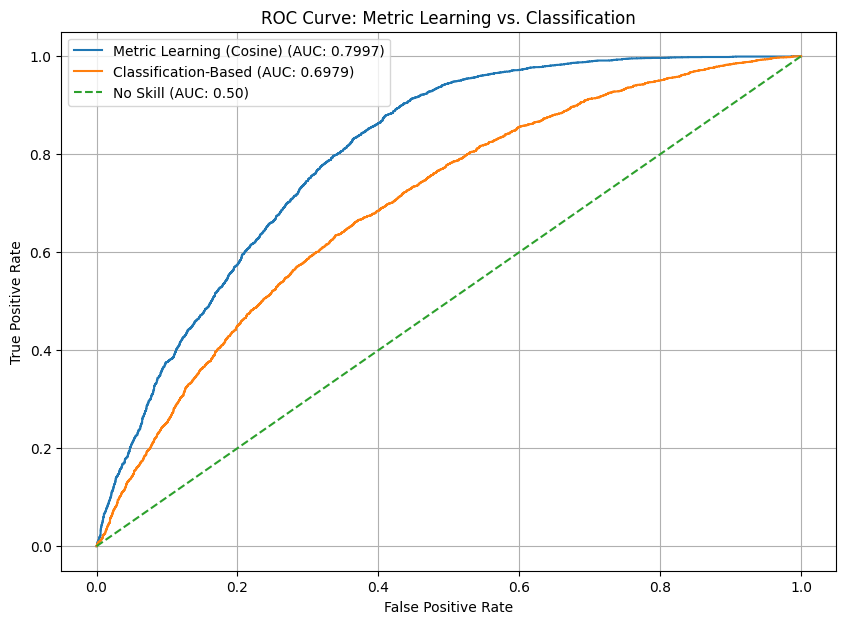

--- Your Final Application Parameters ---
WINNING MODEL: Metric Learning (Cosine)
AUC SCORE: 0.7997
OPTIMAL THRESHOLD (for score > threshold): 0.1681


In [14]:
# --- 3. (FIX 3) Load All Models *Correctly* ---
print("Loading trained models for evaluation...")

# --- Load Metric Model (Cosine) ---
# First, re-create the *exact* architecture you trained
# (We need the 'create_embedding_engine' and 'SiameseModel' classes defined in previous cells)
embedding_engine_cos = create_embedding_engine((*IMAGE_SIZE, 3), EMBEDDING_DIM)
siamese_model_cos = SiameseModel(embedding_engine_cos, "cosine", margin=MARGIN)

# Build the model by passing a dummy batch (this is a Keras requirement)
dummy_batch = (
    tf.zeros((1, *IMAGE_SIZE, 3)),
    tf.zeros((1, *IMAGE_SIZE, 3)),
    tf.zeros((1, *IMAGE_SIZE, 3))
)
_ = siamese_model_cos(dummy_batch)

# Now, load the saved weights from your training
try:
    siamese_model_cos.load_weights("model_siamese_cosine.weights.h5")
    print("Loaded 'model_siamese_cosine.weights.h5' successfully.")
except Exception as e:
    print(f"ERROR: Could not load 'model_siamese_cosine.weights.h5'. Did you run training? Error: {e}")

# Extract the *TRAINED* embedding engine (the "tower")
trained_embedding_cosine = siamese_model_cos.embedding
# Create the 2-input distance model using the *trained* engine
cosine_distance_model = distance_head(trained_embedding_cosine, loss="cosine")

# --- Load Classification Model ---
print("Loading trained Classification model...")

# Re-create the *exact* architecture
# (We need the 'create_classification_model' function defined in your training cell)
base_model_cls_eval = ResNet50(weights=None, include_top=False, input_shape=(*IMAGE_SIZE, 3), pooling='avg')
base_model_cls_eval.trainable = False # Not relevant for inference, but good practice
classification_model_eval = create_classification_model(base_model_cls_eval, num_classes)

# Build the model
_ = classification_model_eval(tf.zeros((1, *IMAGE_SIZE, 3)))

# Load the saved weights
try:
    classification_model_eval.load_weights("model_classification.weights.h5")
    print("Loaded 'model_classification.weights.h5' successfully.")
except Exception as e:
    print(f"ERROR: Could not load 'model_classification.weights.h5'. Did you run training? Error: {e}")

# Extract the *TRAINED* embedding part
# This is the layer we named "embedding_layer"
trained_embedding_classification = Model(
    inputs=classification_model_eval.input,
    outputs=classification_model_eval.get_layer("embedding_layer").output
)

# --- CRITICAL: We must L2-normalize this embedding to compare it fairly ---
# The metric model was normalized, so this one must be too.
norm_output = Lambda(lambda v: tf.math.l2_normalize(v, axis=1))(trained_embedding_classification.output)
final_cls_embedder = Model(inputs=trained_embedding_classification.input, outputs=norm_output)
# Now we create the distance head using the *same cosine distance* for a fair comparison
classification_distance_model = distance_head(final_cls_embedder, loss="cosine")
print("Loaded Classification model and extracted normalized embedding layer.")

# --- 4. Run Predictions ---
print("\nInitializing verification data loader...")
data_verification = FaceVerificationSet(PAIRS_BASE_DIR, PAIRS_FILE, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)
y_true = data_verification.get_y() # Get all true labels (1=same, 0=different)

print("Predicting with Metric (Cosine) Model...")
# A low distance = same person. We want a high *score* for "same" (label 1).
# So, score = 1.0 - distance
scores_cosine = 1.0 - cosine_distance_model.predict(data_verification)

print("Predicting with Classification Model...")
scores_classification = 1.0 - classification_distance_model.predict(data_verification)

# --- 5. Calculate & Plot Metrics ---
auc_cosine = roc_auc_score(y_true, scores_cosine)
auc_classification = roc_auc_score(y_true, scores_classification)

print(f"\n--- FINAL RESULTS ---")
print(f"Metric Learning (Cosine) AUC: {auc_cosine:.4f}")
print(f"Classification-Based AUC:     {auc_classification:.4f}")

fpr_cos, tpr_cos, thresholds_cos = roc_curve(y_true, scores_cosine)
fpr_cls, tpr_cls, thresholds_cls = roc_curve(y_true, scores_classification)

plt.figure(figsize=(10, 7))
plt.plot(fpr_cos, tpr_cos, label=f"Metric Learning (Cosine) (AUC: {auc_cosine:.4f})")
plt.plot(fpr_cls, tpr_cls, label=f"Classification-Based (AUC: {auc_classification:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="No Skill (AUC: 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Metric Learning vs. Classification")
plt.legend()
plt.grid(True)
plt.show()

# --- 6. Find Your Optimal Threshold ---
# This is the "magic number" your app will use
# We find the point on the ROC curve closest to the top-left corner (0,1)
# (This is the J-statistic, which is TPR - FPR)
best_idx = np.argmax(tpr_cos - fpr_cos)
FINAL_THRESHOLD = thresholds_cos[best_idx]
print(f"--- Your Final Application Parameters ---")
print(f"WINNING MODEL: Metric Learning (Cosine)")
print(f"AUC SCORE: {auc_cosine:.4f}")
print(f"OPTIMAL THRESHOLD (for score > threshold): {FINAL_THRESHOLD:.4f}")

In [15]:
# Save the Metric Learning (Cosine) embedding engine to /content
try:
    trained_embedding_cosine.save("/content/metric_learning_embedding_model_cosine.keras")
    print("Metric learning embedding model saved successfully to /content.")
except Exception as e:
    print(f"Error saving metric learning embedding model to /content: {e}")


# Save the Classification-based embedding model to /content
try:
     final_cls_embedder.save("/content/classification_embedding_model.keras")
     print("Classification embedding model saved successfully to /content.")
except Exception as e:
     print(f"Error saving classification embedding model to /content: {e}")

# You can also save just the weights if you prefer:
siamese_model_cos.embedding.save_weights("/content/metric_learning_embedding_weights_cosine.weights.h5")
final_cls_embedder.save_weights("/content/classification_embedding_weights.weights.h5")

Metric learning embedding model saved successfully to /content.
Classification embedding model saved successfully to /content.
